# CAMS-MOS
Demonstration code to download and plot air-quality point forecasts from the CAMS Atmosphere Data Store. Adetailed description is available at the ECMWF documentation website: [CAMS Regional: European Air Quality Forecast Optimised at Observation Sites data documentation](https://confluence.ecmwf.int/display/CKB/CAMS+Regional%3A+European+Air+Quality+Forecast+Optimised+at+Observation+Sites+data+documentation). In this notebook we use the [CAMS European air quality forecasts optimised at observation sites](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts-optimised-at-observation-sites?tab=overview) dataset. . Examples of air quality data used for policy support and decision making are available at the [Policy Support](https://policy.atmosphere.copernicus.eu/) of the CAMS web site.

In [39]:
import os
import sys
import yaml
import json
import cdsapi
import zipfile
import hashlib
import pandas as pd
from math import ceil, sqrt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from zipfile import ZipFile
import warnings
warnings.filterwarnings('ignore')

In [3]:
DATADIR = 'data'
WDIR = f'download'

In [4]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'cams-europe-air-quality-forecasts-optimised-at-observation-sites',
    {
        'format': 'zip',
        'country': 'netherlands',
        'variable': [
            'nitrogen_dioxide', 'ozone', 'particulate_matter_10um',
            'particulate_matter_2.5um',
        ],
        'type': [
            'mos_optimised', 'raw',
        ],
        'leadtime_hour': [
            '0-23', '24-47',
        ],
        'year': '2024',
        'month': '01',
        'day': [
            '27', '28', '29',
            '30', '31',
        ],
        'include_station_metadata': 'yes',
    },
    f'{DATADIR}/{WDIR}.zip')

2024-08-04 14:30:50,992 INFO Welcome to the CDS
2024-08-04 14:30:50,993 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-europe-air-quality-forecasts-optimised-at-observation-sites
2024-08-04 14:30:51,085 INFO Request is completed
2024-08-04 14:30:51,086 INFO Downloading https://download-0003-ads-clone.copernicus-climate.eu/cache-compute-0003/cache/data6/dataset-cams-europe-air-quality-forecasts-optimised-at-observation-sites-b186cf3f-c624-4dbe-a385-9dd6be5fca09.zip to data/download.zip (352.1K)
2024-08-04 14:30:53,150 INFO Download rate 170.6K/s


Result(content_length=360532,content_type=application/zip,location=https://download-0003-ads-clone.copernicus-climate.eu/cache-compute-0003/cache/data6/dataset-cams-europe-air-quality-forecasts-optimised-at-observation-sites-b186cf3f-c624-4dbe-a385-9dd6be5fca09.zip)

In [7]:
# Create a ZipFile Object and load zip file in it
with ZipFile(f'{DATADIR}/{WDIR}.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall(path=f'{DATADIR}/{WDIR}/')

In [31]:
file_list = sorted(zipObj.namelist())
file_list[-1:]

['station_list_20240804.csv']

In [22]:
def read_metadata(file_list, stations):
    """Read the downloaded zip file and return the station metadata and
       concentration data as Pandas DataFrames"""
  
    data = {}
  
    for name in file_list:
        if name.startswith('station_list'):
  
            # Read the station metadata file
            date_fmt = '%Y-%m-%d'
            file_path = DATADIR + '/' + WDIR + '/' + name
            station_data = pd.read_csv(file_path, sep=';', keep_default_na=False)
            # Remove metadata for stations we're not interested in
            if stations:
                station_data = station_data[
                            station_data.id.isin(stations)]
                # Set missing end dates to a date far in the future
                no_end = (station_data.date_end == '')
                station_data.loc[no_end, 'date_end'] = '2099-01-01'
  
                # Parse start and end dates into datetime objects
                station_data.date_start = pd.to_datetime(station_data.date_start, format=date_fmt)
                station_data.date_end = pd.to_datetime(station_data.date_end, format=date_fmt)
    return station_data

In [23]:
# The stations to plot. If None, plot them all.
#stations = None
stations = ['NL00014']

In [26]:
station_data = read_metadata(file_list, stations)
station_data

,id,position_number,lon,lat,alt,date_start,date_end
1849,NL00014,1,4.8662,52.35971,2.0,2024-01-17,2099-01-01


In [30]:
station_list = [item for item in file_list if not item.startswith('station_list')]
station_list[-1:]

['raw_D1_PM25_hourly_2024-01-31_NL.csv']

In [37]:
def read_data(station_list, stations):
    data = {}
    for name in station_list:
        # Read the station metadata file
        date_fmt = '%Y-%m-%d'
        # Read the data file
        file_path = DATADIR + '/' + WDIR + '/' + name
        df = pd.read_csv(file_path, sep=';', parse_dates=['datetime'], infer_datetime_format=True)
        # Remove data for stations we're not interested in
        if stations:
            df = df[df.station_id.isin(stations)]
            # Get the name of the column containing concentration so we
            # can group data by raw/mos type
            data_col = [c for c in df.columns if c.startswith('conc_')]
            assert len(data_col) == 1
            data_col = data_col[0]
            if data_col not in data:
                data[data_col] = []
            data[data_col].append(df)
    return data

In [43]:
data = read_data(station_list, stations)
data.keys()

dict_keys(['conc_mos_micrograms_per_m3', 'conc_raw_micrograms_per_m3'])

In [44]:
def merge_data(data_dict):
    merged_data = None
    for data_col in list(data_dict.keys()):
        # Concatenate all times/countries/species
        x = pd.concat(data[data_col])
        # Merge raw and mos into combined records
        if merged_data is None:
            merged_data = x
        else:
            merged_data = merged_data.merge(x, how='outer', validate='1:1',
                                            on=[c for c in x.columns
                                                if c != data_col])
    return merged_data

In [47]:
merged_data = merge_data(data)
merged_data.head(3)

,station_id,datetime,lead_time_hour,species,conc_mos_micrograms_per_m3,conc_raw_micrograms_per_m3
0,NL00014,2024-01-27 00:00:00,0,NO2,21.9,22.2
1,NL00014,2024-01-27 01:00:00,1,NO2,22.9,23.4
2,NL00014,2024-01-27 02:00:00,2,NO2,25.8,23.8


In [55]:
# Plotting preferences
style = {
        'type': {
            'raw': {'color': 'tab:blue'},
            'mos': {'color': 'tab:orange'}
        },
        'leadtime_day': {
            0: {'linestyle': 'solid'},
            1: {'linestyle': 'dashed'}
        }
    }

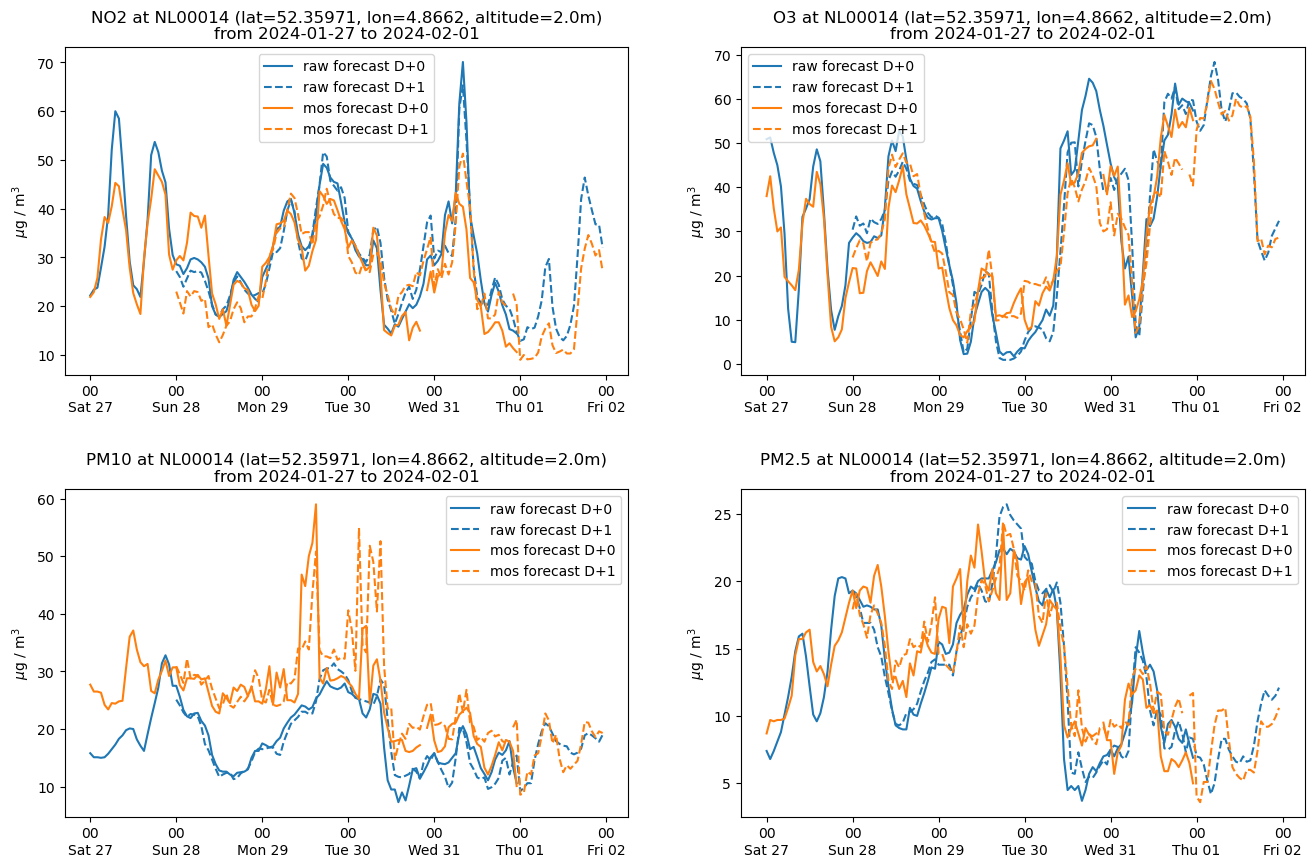

In [56]:
for station in merged_data.station_id.unique():
  
    # Extract station metadata for just this site. If there's more than one
    # entry we take the latest one that's valid within this time period
    sdata = station_data.loc[
            (station_data.id == station) &
            (station_data.date_start <= merged_data.datetime.iloc[-1]) &
            (station_data.date_end >= merged_data.datetime.iloc[0])
    ]
    assert len(sdata), 'No metadata for site?'
    sdata = sdata.iloc[-1, :]
  
    # Extract air quality data for just this site
    adata = merged_data[merged_data.station_id == station]
  
    if len(adata) > 0:
        station_plot(sdata, adata, style)
        #print('Data available for ' + station)
    else:
            print('No data for ' + station)

In [54]:
def station_plot(station, data, style):
    """Make a series of plots for a station - one for each species"""
  
    # Species to plot
    allspecies = data.species.unique()
  
    # Create the figure
    nplotsx = ceil(sqrt(len(allspecies)))
    nplotsy = ceil(len(allspecies) / nplotsx)
    fig = plt.figure(figsize=(nplotsx*8, nplotsy*5))
    fig.subplots_adjust(hspace=0.35)
  
    # Plot each species
    for iplot, species in enumerate(allspecies):
        ax = plt.subplot(nplotsy, nplotsx, iplot + 1)
  
        # Extract data for just this species
        sdata = data[data.species == species]
  
        plot_species(station, sdata, style, ax)
  
    plt.show()

In [51]:
def plot_species(station, data, style, ax):
    """Make a plot for one species at one station"""
  
    allspecies = data.species.unique()
    assert len(allspecies) == 1
  
    # Plotting both raw and mos-corrected or just one?
    types = [t for t in ['raw', 'mos']
             if f'conc_{t}_micrograms_per_m3' in data.columns]
  
    # Plot different lines for each post-processing type and lead time day
    for type in types:
        lead_time_day = data.lead_time_hour // 24
        for day in lead_time_day.unique():
            dt = data[lead_time_day == day]
  
            ax.plot(dt.datetime, dt[f'conc_{type}_micrograms_per_m3'],
                    label=f'{type} forecast D+{day}',
                    **prefs(type, day, style))
  
    # Nicer date labels
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H\n%a %d'))
  
    ax.set_ylabel('$\mu$g / m$^3$')
  
    date_range = 'from ' + ' to '.join(data.datetime.iat[i].strftime('%Y-%m-%d')
                                       for i in [0, -1])
    ax.set_title(
        ('{species} at {station} (lat={lat}, lon={lon}, altitude={alt}m)\n'
         '{dates}').format(species=allspecies[0],
                           station=station.id,
                           lat=station.lat,
                           lon=station.lon,
                           alt=station.alt,
                           dates=date_range))
  
    ax.legend()

In [52]:
def prefs(type, leadtime, style):
    """Return pyplot.plot() keyword arguments for given type and leadtime"""
  
    return {**style.get('type', {}).get(type, {}),
            **style.get('leadtime_day', {}).get(leadtime, {})}